# Semi-Supervised Learning with VAE on Fashion MNIST

This notebook implements semi-supervised learning using Variational Autoencoders (VAEs) on the Fashion MNIST dataset, followed by training an SVM classifier using the features extracted from the VAE. We experiment with different numbers of labeled examples to evaluate the performance of our semi-supervised approach.

## 1. Setup

Start by importing the necessary libraries and setting up the environment.


In [1]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
from data.cifar10_data import get_cifar10_data
from data.mnist_data import get_mnist_data, get_fashion_mnist_data
from model.dcgan import DCGAN
from model.wgan import WGAN
from torch.utils.tensorboard import SummaryWriter


%load_ext autoreload
%autoreload 2



## 2. Hyperparameters

Here, we define the hyperparameters for our experiments.


In [2]:
# Hyperparameters
nz = 100
lr = 0.00005
batch_size = 64
n_critic = 2
clamp_value = 0.01
n_iter = 20000
dataset = 'fashion_mnist'  # Change this to 'mnist' or 'fashion_mnist' for different datasets
gan_type = 'dcgan'  # Change this to 'dcgan' for DCGAN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cpu


## 3. Dataset Handling


In [3]:
# Get data loader
if dataset == 'cifar10':
    data_loader = get_cifar10_data(batch_size)
    channels = 3
elif dataset == 'mnist':
    data_loader = get_mnist_data(batch_size)
    channels = 1
elif dataset == 'fashion_mnist':
    data_loader = get_fashion_mnist_data(batch_size)
    channels = 1
else:
    raise ValueError("Invalid dataset")


In [4]:
# Function to plot generated samples
def plot_generated_samples(epoch, noise, gan):
    with torch.no_grad():
        fake_images = gan.netG(noise).detach().cpu()

    # Handle both grayscale and RGB images
    if fake_images.shape[1] == 1:
        fake_images = fake_images.repeat(1, 3, 1, 1)  # Convert grayscale to RGB for plotting

    grid = torchvision.utils.make_grid(fake_images, padding=2, normalize=True)
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(f'Generated Images at Epoch {epoch}')
    plt.axis('off')  # Hide axis
    plt.show()
    
    return grid

Epoch [0/20000] | D_loss: 1.353 | G_loss: 1.134:   0%|          | 0/20000 [00:18<?, ?it/s]

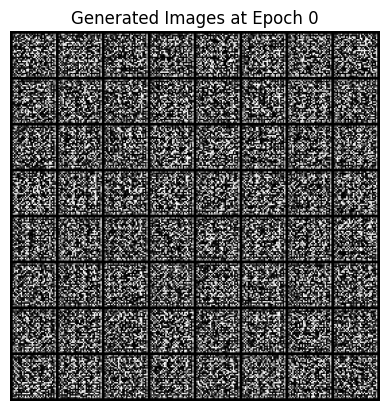

Epoch [100/20000] | D_loss: 0.026 | G_loss: 5.140:   0%|          | 100/20000 [01:35<4:15:57,  1.30it/s]

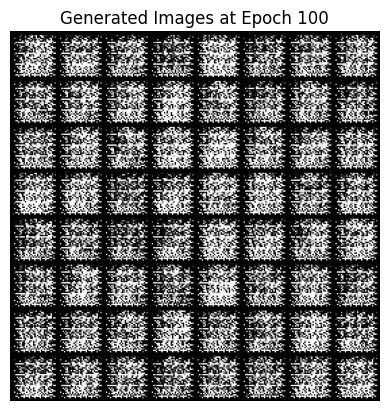

Epoch [200/20000] | D_loss: 0.005 | G_loss: 6.229:   1%|          | 200/20000 [03:01<5:25:20,  1.01it/s]

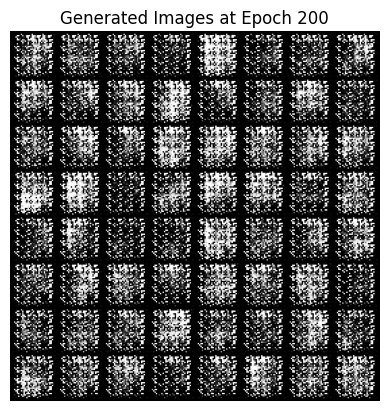

Epoch [300/20000] | D_loss: 0.003 | G_loss: 6.515:   2%|▏         | 300/20000 [04:44<5:47:36,  1.06s/it]

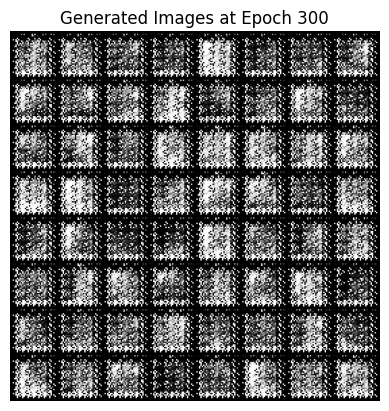

Epoch [390/20000] | D_loss: 0.001 | G_loss: 7.183:   2%|▏         | 391/20000 [06:15<5:14:04,  1.04it/s]


KeyboardInterrupt: 

In [5]:
# Initialize TensorBoard Writer
writer = SummaryWriter()

if gan_type == 'wgan':
    gan = WGAN(nz, lr, device, channels=channels)
else:
    gan = DCGAN(nz, lr, device, channels=channels)


fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)  # Fixed noise for consistent samples
# Lists to store losses
D_losses = []
G_losses = []

# Training loop
data_iter = iter(data_loader)
pbar = tqdm(range(n_iter))

for epoch in pbar:
    if gan_type == 'wgan':
        for p in gan.netD.parameters():
            p.requires_grad = True

    for i in range(gan.n_critic if gan_type == 'wgan' else 1):
        try:
            real_data = next(data_iter)
        except StopIteration:
            data_iter = iter(data_loader)
            real_data = next(data_iter)

        real_data = real_data[0].to(device)
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_data = gan.netG(noise)

        D_loss = gan.train_discriminator(real_data, fake_data)
        D_losses.append(D_loss.item())

    if gan_type == 'wgan':
        for p in gan.netD.parameters():
            p.requires_grad = False

    G_loss = gan.train_generator(fake_data)
    G_losses.append(G_loss.item())

    # Log losses to TensorBoard
    writer.add_scalar('Loss/Discriminator', D_loss.item(), epoch)
    writer.add_scalar('Loss/Generator', G_loss.item(), epoch)

    # Update tqdm progress bar
    pbar.set_description(f"Epoch [{epoch}/{n_iter}] | D_loss: {D_loss.item():.3f} | G_loss: {G_loss.item():.3f}")

    # Plot generated samples
    if epoch % 100 == 0:
        grid = plot_generated_samples(epoch, fixed_noise, gan)
        writer.add_image(f'Generated Images at Epoch {epoch}', grid, epoch)

# Close TensorBoard writer
writer.close()

# Save the models
save_path = './models'

# Save the models
if not os.path.exists(save_path):
    os.makedirs(save_path)
torch.save(gan.netG.state_dict(), os.path.join(save_path, f'{gan_type}_generator.pth'))
torch.save(gan.netD.state_dict(), os.path.join(save_path, f'{gan_type}_discriminator.pth'))

# Plot loss curves
plt.figure()
plt.plot(D_losses, label='Discriminator Loss')
plt.plot(G_losses, label='Generator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Losses')
plt.show()

# Generate some samples
noise = torch.randn(batch_size, nz, 1, 1, device=device)
fake_images = gan.netG(noise).detach().cpu()

# Plot generated images
if fake_images.shape[1] == 1:
    fake_images = fake_images.repeat(1, 3, 1, 1)
grid = torchvision.utils.make_grid(fake_images, padding=2, normalize=True)
plt.imshow(grid.permute(1, 2, 0))
plt.title('Generated Images')
plt.axis('off')
plt.show()